In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / 'src'))

%load_ext autoreload
%autoreload 1
%aimport regressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 0: Pre-processing

### Loading the data

Our CSV file is unlabeled, so we create our column names following the description in spambase.DOCUMENTATION:

In [316]:
word_freq_names = [f'word_freq_{i}' for i in range(1, 49)]
char_freq_names = [f'char_freq_{i}' for i in range(1, 7)]
cap_run_features = ['capital_run_length_' + s for s in ['average', 'longest', 'total']]

col_names = (
    word_freq_names +
    char_freq_names +
    cap_run_features +
    ['spam']
)

In [317]:
df = pd.read_csv('../data/spambase.data', header=None, names=col_names)
df.head()

,word_freq_1,word_freq_2,word_freq_3,word_freq_4,word_freq_5,word_freq_6,word_freq_7,word_freq_8,word_freq_9,word_freq_10,...,char_freq_1,char_freq_2,char_freq_3,char_freq_4,char_freq_5,char_freq_6,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Feature normalization

We can see that the ranges of the values for our integral features are quite large relative to our word and char frequencies:

In [318]:
df[cap_run_features].describe()

,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,4601.000000,4601.000000,4601.000000
mean,5.191515,52.172789,283.289285
std,31.729449,194.891310,606.347851
min,1.000000,1.000000,1.000000
25%,1.588000,6.000000,35.000000
50%,2.276000,15.000000,95.000000
75%,3.706000,43.000000,266.000000
max,1102.500000,9989.000000,15841.000000


I tried to train the regressor without normalizing at first, but the sigmoid function saturated, and we were getting numerical issues of taking logs of 0 in our cross entropy loss as a consequence. To address this, we min-max normalize all of our features.

In [319]:
minima = df.min()
maxima = df.max()

df = (df - minima) / (maxima - minima) 

In [320]:
df.describe()

,word_freq_1,word_freq_2,word_freq_3,word_freq_4,word_freq_5,word_freq_6,word_freq_7,word_freq_8,word_freq_9,word_freq_10,...,char_freq_1,char_freq_2,char_freq_3,char_freq_4,char_freq_5,char_freq_6,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.023029,0.014917,0.055031,0.001528,0.031222,0.016310,0.015709,0.009477,0.017123,0.013169,...,0.008797,0.014257,0.004160,0.008285,0.012629,0.002231,0.003805,0.005123,0.017821,0.394045
std,0.067259,0.090376,0.098852,0.032589,0.067251,0.046569,0.053843,0.036100,0.052969,0.035465,...,0.055524,0.027723,0.026806,0.025115,0.040960,0.021652,0.028806,0.019513,0.038280,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000534,0.000501,0.002146,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.006665,0.000000,0.000000,0.000000,0.000000,0.001158,0.001402,0.005934,0.000000
75%,0.000000,0.000000,0.082353,0.000000,0.038000,0.000000,0.000000,0.000000,0.000000,0.008801,...,0.000000,0.019278,0.000000,0.009699,0.008662,0.000000,0.002457,0.004205,0.016730,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Random Seed

For reproducibility, we'll set the seed for the random generators we use (e.g. for train-test spliiting, stochastic gradient descent, etc...).

In [321]:
rng_seed = 551
rng = np.random.default_rng(seed=rng_seed)

### Train-test split

We'll implement a train-test split of 5-95, that is, we use 5% of the data for training, and hold out the remaining 95% for testing. (In the interest of implementing our classifier from 'scratch', we don't use train_test_split from scikit-learn.)

In [322]:
train_ratio = 0.05
N = len(df)

# Train-test split
df_perm = df.iloc[rng.permutation(N)]
split_index = int(N * train_ratio)
df_train = df_perm.iloc[:split_index]
df_test = df_perm.iloc[split_index:]

X_train = df_train.drop(columns=['spam'])
y_train = df_train['spam']
X_test = df_test.drop(columns=['spam'])
y_test = df_test['spam']

## Task 1: Logistic Regression with SGD

In [323]:
from regressor import LogisticRegressor

We'll initialize two logistic regressors, one with no regularization and the other with regularization strength 0.001, to compare their loss curves. As a bonus, will initialize another logistic regressor with beta (called momentum_rate in our code) set to 0.999, where our $t$th update step becomes

$$ M^{(t)} = \beta M^{(t-1)} + (1 - \beta)\nabla_w J(w)$$
$$ w^{(t)} = w - \alpha * M^{(t)}$$

We'll initialize our hyperparameters as follows:

In [324]:
reg_str_init = 0.001
batch_size_init = 1
learning_rate_init = 0.001
num_epochs_init = 100
momentum_rate_init = 0.9995

In [325]:
import warnings
warnings.filterwarnings("error")

In [326]:
model_basic = LogisticRegressor(
    batch_size=batch_size_init,
    learning_rate=learning_rate_init,
    num_epochs=num_epochs_init,
    seed=2026
)

model_reg = LogisticRegressor(
    batch_size=batch_size_init,
    learning_rate=learning_rate_init,
    num_epochs=num_epochs_init,
    regularization_strength=reg_str_init, 
    seed=2026
)

model_mom = LogisticRegressor(
    batch_size=batch_size_init,
    learning_rate=learning_rate_init,
    num_epochs=num_epochs_init,
    momentum_rate = momentum_rate_init, 
    seed=2026
)

learning_curve_basic = model_basic.fit(
    X_train.to_numpy(), 
    y_train.to_numpy(), 
    learning_curve=True
)

learning_curve_reg = model_reg.fit(
    X_train.to_numpy(), 
    y_train.to_numpy(), 
    learning_curve=True
)               

learning_curve_mom = model_mom.fit(
    X_train.to_numpy(), 
    y_train.to_numpy(), 
    learning_curve=True
)       

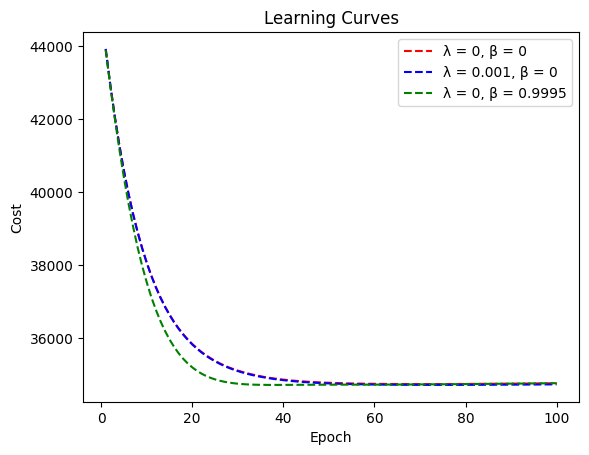

In [328]:
plt.plot(np.arange(1, model_basic.num_epochs + 1), 
            learning_curve_basic, 
            'r--', label='\u03BB = 0, \u03B2 = 0')
plt.plot(np.arange(1, model_reg.num_epochs + 1),
            learning_curve_reg,
            'b--', label=f'\u03BB = {reg_str_init}, \u03B2 = 0')
plt.plot(np.arange(1, model_mom.num_epochs + 1),
            learning_curve_mom,
            'g--', label=f'\u03BB = 0, \u03B2 = {momentum_rate_init}')

plt.xlabel("Epoch") 
plt.ylabel("Cost")
plt.title("Learning Curves")
plt.legend()